# **Hedging via Finite Differences: PIDE Method**





<font color='Blue'>**Overheads**</font>

In [1]:
from scipy import sparse
from scipy.sparse.linalg import splu
import scipy as scp
import scipy.stats as ss
from scipy import signal
from scipy.integrate import quad
import scipy.special as scps

from time import time

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

from math import factorial

<font color='Blue'>**Process Information**</font>

In [2]:
class Merton_process():
    """
    Class for the Merton process:
    r = risk free constant rate
    sig = constant diffusion coefficient
    lam = jump activity
    muJ = jump mean
    sigJ = jump standard deviation
    """
    def __init__(self, r, sig, lam , muJ, sigJ):
        self.r = r
        self.lam = lam
        self.muJ = muJ
        if (sig<0 or sigJ<0):
            raise ValueError("sig and sigJ must be positive")
        else:
            self.sig = sig
            self.sigJ = sigJ
        
        # moments
        self.var = self.sig**2 + self.lam * self.sigJ**2 + self.lam * self.muJ**2
        self.skew = self.lam * (3* self.sigJ**2 * self.muJ + self.muJ**3) / self.var**(1.5)
        self.kurt = self.lam * (3* self.sigJ**3 + 6 * self.sigJ**2 * self.muJ**2 + self.muJ**4) / self.var**2
     
    def exp_RV(self, S0, T, N):
        m = self.lam * (np.exp(self.muJ + (self.sigJ**2)/2) -1)    # coefficient m
        W = ss.norm.rvs(0, 1, N)              # The normal RV vector  
        P = ss.poisson.rvs(self.lam*T, size=N)    # Poisson random vector (number of jumps)
        Jumps = np.asarray([ss.norm.rvs(self.muJ, self.sigJ, ind).sum() for ind in P ]) # Jumps vector
        S_T = S0 * np.exp( (self.r - 0.5*self.sig**2 -m )*T + np.sqrt(T)*self.sig*W + Jumps )     # Martingale exponential Merton
        return S_T.reshape((N,1))

<font color='Blue'>**Option Information**</font>

In [3]:
class Option_param():
    """
    Option class wants the option parameters:
    S0 = current stock price
    K = Strike price
    T = time to maturity
    v0 = (optional) spot variance 
    exercise = European or American
    """
    def __init__(self, S0=15, K=15, T=1, v0=0.04, payoff="call", exercise="European"):
      self.S0 = S0
      self.v0 = v0
      self.K = K
      self.T = T
        
      if (exercise=="European" or exercise=="American"):
        self.exercise = exercise
      else: 
        raise ValueError("invalid type. Set 'European' or 'American'")
        
      if (payoff=="call" or payoff=="put"):
        self.payoff = payoff
      else: 
        raise ValueError("invalid type. Set 'call' or 'put'")

<font color='Blue'>**Computation of Option Price via Finite Differences**</font>

In [4]:
class Merton_pricer():
    """
    Closed Formula.
    Monte Carlo.
    Finite-difference PIDE: Explicit-implicit scheme         
    
        0 = dV/dt + (r -(1/2)sig^2 -m) dV/dx + (1/2)sig^2 d^V/dx^2
                 + \int[ V(x+y) nu(dy) ] -(r+lam)V  
    """
    def __init__(self, Option_info, Process_info):
        """
        Process_info:  of type Merton_process. It contains (r, sig, lam, muJ, sigJ) i.e.  
        interest rate, diffusion coefficient, jump activity and jump distribution parameters
    
        Option_info:  of type Option_param. It contains (S0,K,T) i.e. current price, strike, maturity in years
        """
        self.r = Process_info.r           # interest rate
        self.sig = Process_info.sig       # diffusion coefficient
        self.lam = Process_info.lam       # jump activity
        self.muJ = Process_info.muJ       # jump mean
        self.sigJ = Process_info.sigJ     # jump std
        self.exp_RV = Process_info.exp_RV # function to generate exponential Merton Random Variables
        
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        
        self.price = 0
        self.S_vec = None
        self.price_vec = None
        self.mesh = None
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
             
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff     
            
    
    def PIDE_price(self, steps, Time=False):
        """
        steps = tuple with number of space steps and time steps (Nspace,Ntime)
        payoff = "call" or "put"
        exercise = "European" or "American"
        Time = Boolean. Execution time.
        """
        t_init = time()
        
        Nspace = steps[0]   
        Ntime = steps[1]
        self.Ntime = Ntime
        
        S_max = 6*float(self.K)                
        S_min = float(self.K)/6
        x_max = np.log(S_max)
        x_min = np.log(S_min) 
        
        dev_X = np.sqrt(self.lam * self.sigJ**2 + self.lam * self.muJ**2)    
        # standard deviation of jump (compare variance of compound poisson process)
        
        dx = (x_max - x_min)/(Nspace-1)            # (N-1) since here: x_min = x_1,...,x_N = x_max
        self.dx = dx
        extraP = int(np.floor(5*dev_X/dx))         # extra points beyond the B.C.
        #  Idea: cover at least 5 standard deviations of the domain of the Lévy measure in each direction
        x = np.linspace(x_min-extraP*dx, x_max+extraP*dx, Nspace + 2*extraP)   # space discretization
        t, dt = np.linspace(0, self.T, Ntime, retstep=True)       # time discretization
        self.dt = dt
        
        Payoff = self.payoff_f(np.exp(x)) # Payoff = terminal payoff for all possible x values
        offset = np.zeros(Nspace-2) # offset = middle points
        V = np.zeros((Nspace + 2*extraP, Ntime)) # grid initialization: different to paper, here rows=space and columns=time
        
        if self.payoff == "call":
            V[:,-1] = Payoff # terminal conditions in last time columnm
            V[-extraP-1:,:] = np.exp(x[-extraP-1:]).reshape(extraP+1,1) * np.ones((extraP+1,Ntime)) - \
                 self.K * np.exp(-self.r* t[::-1] ) * np.ones((extraP+1,Ntime))  # boundary condition
            # the last extraP+1 (including A2) rows: (equals x -> infinity) exp(x) - K*exp(-r(T-t)) (t[::-1] = reversed t)
            V[:extraP+1,:] = 0         # the first extraP+1 (including A1) rows: (equals x -> -infinity) 0
        else:    
            V[:,-1] = Payoff
            V[-extraP-1:,:] = 0
            V[:extraP+1,:] = self.K * np.exp(-self.r* t[::-1] ) * np.ones((extraP+1,Ntime))
            # for put: x -> - infinity, V = K*exp(-r*(T-t))
            #          x -> + infinity, V = 0
        
        # nu(dz) = lambda*norm.pdf(mean=muJ,stddev=sigJ)*dz
        # Approximation: nu_k = int_{(k-1/2)dx}^{(k+1/2)dx}nu(z) dz for -K1<=k<=K2
        # -B1 = (-K1-1/2)*dx and -B1 = -(extraP)dx -> extraP = K1 + 1/2
        # [0] because cdf = array([[result]])
        # [-B1,B2] in [(-K1-1/2)*dx,(K2+1/2)*dx] (strict inclusion), therefore: -B1 >= (-K1-1/2)*dx, extraP <= K1+1/2 = extraP + 1.5
        # -B1 = - extraP*dx and B2 = extraP*dx in order to ensure inclusion: +1.5
        cdf = ss.norm.cdf([np.linspace(-(extraP+1+0.5)*dx, (extraP+1+0.5)*dx, 2*(extraP+2))], loc=self.muJ, scale=self.sigJ)[0]
        nu = self.lam * (cdf[1:] - cdf[:-1])      # compute integral via fundamental theorem of calculus (Anti-derivative of pdf is cdf)  
        
        lam_appr = sum(nu)
        # m_approx = sum((exp(y_j)-1)*v_j), @ = matrix multiplication
        m_appr = np.array([ np.exp(i*dx)-1 for i in range(-(extraP+1), extraP+2)]) @ nu
        
        sig2 = self.sig**2 
        dxx = dx**2
        a = ( (dt/2) * ( (self.r -m_appr -0.5*sig2)/dx - sig2/dxx ) )
        b = ( 1 + dt * ( sig2/dxx + self.r + lam_appr) )
        c = (-(dt/2) * ( (self.r -m_appr -0.5*sig2)/dx + sig2/dxx ) )
        
        D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc() # only inner points (without boundary)
        # csc = Compressed Sparse Column matrix
        DD = splu(D)         # splu = LU decomposition
        if self.exercise=="European":        
            for i in range(Ntime-2,-1,-1):
                offset[0] = a * V[extraP,i]       # boundary terms
                offset[-1] = c * V[-1-extraP,i]   # boundary terms
                V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="fft")
                V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )
        elif self.exercise=="American":
            for i in range(Ntime-2,-1,-1):
                offset[0] = a * V[extraP,i]
                offset[-1] = c * V[-1-extraP,i]
                V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="fft")
                V[extraP+1 : -extraP-1, i] = np.maximum( DD.solve( V_jump - offset ), Payoff[extraP+1 : -extraP-1] )
                
        X0 = np.log(self.S0) # current log-price
        self.S_vec = np.exp(x[extraP+1 : -extraP-1]) # vector of S
        self.price = np.interp(X0, x, V[:,0])
        self.price_vec = V[extraP+1 : -extraP-1,0]
        self.price_matrix = V
        self.logS = x
        self.mesh = V[extraP+1 : -extraP-1, :]
        
        if (Time == True):
            elapsed = time()-t_init
            return self.price, elapsed
        else:
            return(self.price,self.price_matrix,self.logS)


    def plot(self, axis=None):
        if (type(self.S_vec) != np.ndarray or type(self.price_vec) != np.ndarray):
            self.PIDE_price((5000,4000))
            
        plt.plot(self.S_vec, self.payoff_f(self.S_vec) , color='blue',label="Payoff")
        plt.plot(self.S_vec, self.price_vec, color='red',label="Merton curve")
        if (type(axis) == list):
            plt.axis(axis)
        plt.xlabel("S"); plt.ylabel("price"); plt.title("Merton price")
        plt.legend(loc='upper left')
        plt.show()
        
    def mesh_plt(self):
        if (type(self.S_vec) != np.ndarray or type(self.mesh) != np.ndarray):
            self.PDE_price((7000,5000))
            
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        X, Y = np.meshgrid( np.linspace(0, self.T, self.mesh.shape[1]) , self.S_vec)
        ax.plot_surface(Y, X, self.mesh, cmap=cm.ocean)
        ax.set_title("Merton price surface")
        ax.set_xlabel("S"); ax.set_ylabel("t"); ax.set_zlabel("V")
        ax.view_init(30, -100) # this function rotates the 3d plot
        plt.show() 
    
    def delta_hedge(self,Ssim):
        def get_pos(x,S):
          Nhedge = S.shape[1] # number of hedging steps
          pos = np.zeros(Nhedge)
          S_log = np.log(S)
          for i in range(Nhedge):
            pos[i] = np.where(x>=S_log[0,i])[0][0]
          return(pos.astype(int))

        self.Ssim = Ssim # simulated S values
        Nhedge = S.shape[1] # number of hedging steps
        positions = get_pos(self.logS,Ssim)
        phi = np.zeros(Nhedge-1)
        dt_hedge = self.T/(Nhedge-1)

        for i in range(Nhedge-1):
          get_timecol = int(np.round(i*dt_hedge/self.dt))
          V_t = self.price_matrix[:,get_timecol]
          pos = positions[i]
          phi[i] = (V_t[pos+1] - V_t[pos])/self.dx
        return(phi)

    def deltagamma_hedge(self,Ssim,Hedgeoption):
        def get_pos(x,S):
          Nhedge = S.shape[1] # number of hedging steps
          pos = np.zeros(Nhedge)
          S_log = np.log(S)
          for i in range(Nhedge):
            pos[i] = np.where(x>=S_log[0,i])[0][0]
          return(pos.astype(int))

        self.Ssim = Ssim # simulated S values
        Nhedge = S.shape[1] # number of hedging steps
        positions = get_pos(self.logS,Ssim)

        phi = np.zeros(Nhedge-1)
        gamma = np.zeros(Nhedge-1)
        phi_hedgeoption = np.zeros(Nhedge-1)
        delta = np.zeros(Nhedge-1)

        dt_hedge = self.T/(Nhedge-1)

        for i in range(Nhedge-1):
          get_timecol = int(np.round(i*dt_hedge/self.dt))
          V_t = self.price_matrix[:,get_timecol]
          VH_t = Hedgeoption[:,get_timecol]
          pos = positions[i]
          phi[i] = (V_t[pos+1] - V_t[pos])/self.dx
          gamma[i] = (V_t[pos+1] - 2*V_t[pos] + V_t[pos])/(VH_t[pos+1] - 2*VH_t[pos] + VH_t[pos])
          phi_hedgeoption[i] = (VH_t[pos+1] - VH_t[pos])/self.dx
        
        delta = phi - gamma*phi_hedgeoption

        return(delta,gamma)

In [5]:
class MertonJumpProcess:
    def __init__(self, s0=None, sigma=None, risk_free=None,
                 jump_intensity=None, jump_mean=None,
                 jump_volatility=None, seed=0):
        self.s0 = s0
        self.sigma = sigma
        self.risk_free = risk_free
        self.seed = seed
        self.jump_intensity = jump_intensity
        self.jump_volatility = jump_volatility
        self.jump_mean = jump_mean

    def gen_paths(self, length=None, time_step=None, num_paths=None):
        size = (time_step, num_paths)
        dt = length/time_step
        
        S = np.zeros((time_step+1, num_paths))
        S[0,:] = self.s0
        poi_rv = np.multiply(np.random.poisson(self.jump_intensity*dt, size=size),
                             np.random.normal(self.jump_mean, self.jump_volatility, size=size)).cumsum(axis=0)
        geo = np.cumsum(((self.risk_free - self.sigma**2/2 - \
                        self.jump_intensity*(self.jump_mean + self.jump_volatility**2*0.5))*dt + \
                        self.sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
        S[1:time_step+1,:] = np.exp(geo+poi_rv)*self.s0
        
        return np.transpose(S) #np.tranpose() to make the dimensions coincide with BlackScholesProcess 

**Test of option pricing**: Comparison to closed-form version for deep hedging was successful.

In [6]:
def get_pos(x,S):
  N = S.shape[1]
  pos = np.zeros(N)
  S_log = np.log(S)
  for i in range(N):
    pos[i] = np.where(x>=S_log[0,i])[0][0]
  return(pos.astype(int))

In [7]:
lam = 1.5
sig = 0.2
muJ = 0
sigJ = 0.2
S0 = 100
K = 100
Khedge = 1.05*K

opt_param = Option_param(S0=S0, K=K, T=30/365, exercise="European", payoff="call" )
Merton_param = Merton_process(r=0.0, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
Merton = Merton_pricer(opt_param, Merton_param)
p = Merton.PIDE_price((1200,1000), Time=False) # Price at t=0
V = p[1] # Price matrix for all time steps and all prices of S
x = p[2] # Vector of space discretization of log(S)
t_vec, dt = np.linspace(0, 30/365, 1000, retstep=True) # Vector of time discretization
print("The price of the opiton at t=0 is",np.round(p[0],decimals=2),".")

# How to get value of call at certain time step for certan stock price:
t = 2/365
S_t = 98.10729502
n = int(np.round(t/dt))
C_t = np.interp(np.log(S_t), x, V[:,n])
print("The value of the option at time", np.round(t,decimals=4), "and stock value", 
      np.round(S_t,decimals=2), "is", np.round(C_t,decimals=2),".")

The price of the opiton at t=0 is 3.02 .
The value of the option at time 0.0055 and stock value 98.11 is 2.06 .


<font color='Blue'>**Hedging Methods: Delta & Delta-Gamma Hedge**</font>

In [8]:
time_step = 30
maturity = 30/365
S = MertonJumpProcess(s0=S0,sigma=sig,risk_free=0.0,jump_intensity=lam,
                      jump_volatility=sigJ,jump_mean=muJ).gen_paths(length=maturity,
                                                                 time_step=time_step,
                                                                 num_paths=1)
delta = Merton.delta_hedge(S)
PNL_delta = 0
for i in range(30):
  PNL_delta += delta[i]*(S[0,i+1]-S[0,i])
payoff = np.max((0,S[0,-1]-K))
PNL_delta = PNL_delta - payoff + p[0]

opt_param_2 = Option_param(S0=S0, K=Khedge, T=30/365, exercise="European", payoff="call" )
Merton_param_2 = Merton_process(r=0.0, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
Merton_2 = Merton_pricer(opt_param_2, Merton_param_2)
p2 = Merton_2.PIDE_price((1200,1000), Time=False) # Price at t=0
C_hedge = p2[1] # Price matrix for all time steps and all prices of S

delta, gamma = Merton.deltagamma_hedge(S,C_hedge)
PNL_deltagamma = 0
positions = get_pos(x,S)
dt_hedge = maturity/time_step

for i in range(time_step):
  pos = positions[i]
  pos_next = positions[i+1]
  get_timecol = int(np.round(i*dt_hedge/dt))
  get_timecol_next = int(np.round((i+1)*dt_hedge/dt))
  VH_t = C_hedge[:,get_timecol]
  VH_tnext = C_hedge[:,get_timecol_next]
  PNL_deltagamma += delta[i]*(S[0,i+1]-S[0,i]) + gamma[i]*(VH_tnext[pos_next]-VH_t[pos])

PNL_deltagamma = PNL_deltagamma - payoff + p[0]

print("PNL Delta Hedge:", PNL_delta)
print("PNL Delta-Gamma Hedge:", PNL_deltagamma)

PNL Delta Hedge: 148.1810823144302
PNL Delta-Gamma Hedge: 0.20365210522320787


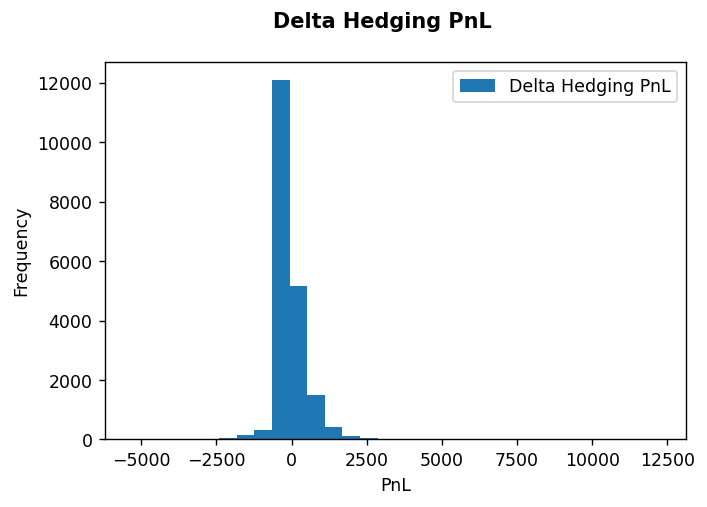

In [9]:
num_paths = 20000
S_multi = MertonJumpProcess(s0=S0,sigma=sig,risk_free=0.0,jump_intensity=lam,
                      jump_volatility=sigJ,jump_mean=muJ).gen_paths(length=maturity,
                                                                 time_step=time_step,
                                                                 num_paths=num_paths)
PNL_delta_multi = np.zeros(num_paths)

for i in range(num_paths):
  S_i = S_multi[i,:].reshape(1,time_step+1)
  delta = Merton.delta_hedge(S_i)
  for j in range(30):
    PNL_delta_multi[i] += delta[j]*(S_i[0,j+1]-S_i[0,j])
  payoff = np.max((0,S_i[0,-1]-K))
  PNL_delta_multi[i] = PNL_delta_multi[i] - payoff + p[0]

fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Delta Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist(PNL_delta_multi, bins=30, \
          label=["Delta Hedging PnL"])
ax.legend()
plt.show()

In [10]:
import pandas as pd
import numpy as np

df_describe = pd.DataFrame(PNL_delta_multi)
df_describe.describe()

,0
count,20000.000000
mean,-2.634061
std,609.516539
min,-5335.708817
25%,-247.051721
50%,-193.866548
75%,138.510571
max,12231.809027


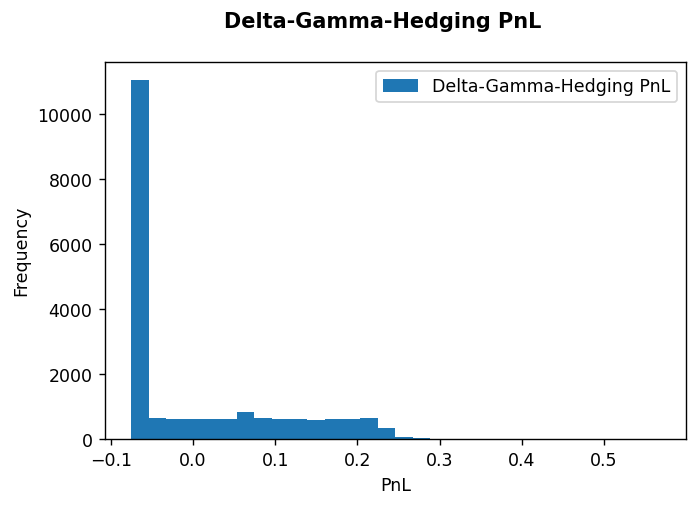

In [11]:
PNL_deltagamma_multi = np.zeros(num_paths)

opt_param_2 = Option_param(S0=S0, K=Khedge, T=30/365, exercise="European", payoff="call" )
Merton_param_2 = Merton_process(r=0.0, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
Merton_2 = Merton_pricer(opt_param_2, Merton_param_2)
p2 = Merton_2.PIDE_price((1200,1000), Time=False) # Price at t=0
C_hedge = p2[1] # Price matrix for all time steps and all prices of S


for i in range(num_paths):
  S_i = S_multi[i,:].reshape(1,time_step + 1)
  delta, gamma = Merton.deltagamma_hedge(S_i,C_hedge)
  positions = get_pos(x,S_i)
  dt_hedge = maturity/time_step

  for j in range(time_step):
      pos = positions[j]
      pos_next = positions[j+1]
      get_timecol = int(np.round(j*dt_hedge/dt))
      get_timecol_next = int(np.round((j+1)*dt_hedge/dt))
      VH_t = C_hedge[:,get_timecol]
      VH_tnext = C_hedge[:,get_timecol_next]
      PNL_deltagamma_multi[i] += delta[j]*(S_i[0,j+1]-S_i[0,j]) + gamma[j]*(VH_tnext[pos_next]-VH_t[pos])

  payoff = np.max((0,S_i[0,-1]-K))
  PNL_deltagamma_multi[i] = PNL_deltagamma_multi[i] - payoff + p[0]

fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Delta-Gamma-Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist(PNL_deltagamma_multi, bins=30, \
          label=["Delta-Gamma-Hedging PnL"])
ax.legend()
plt.show()

In [12]:
df_describe = pd.DataFrame(PNL_deltagamma_multi)
df_describe.describe()

,0
count,20000.000000
mean,0.000691
std,0.101696
min,-0.075300
25%,-0.075300
50%,-0.075300
75%,0.074250
max,0.567405
